<a href="https://colab.research.google.com/github/hiiprtv/AI-Playstyle-Archetype-Finder/blob/main/AI_Playstyle_Archetype_Finder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Simulated Data Generated: 300 players ---
  Player_ID  Pass_Freq_per_90  Shot_Attempts_per_90  Risk_Index  \
0  Player_1        101.570748              1.957985    0.352303   
1  Player_2         99.259542              2.616672    0.276743   
2  Player_3         98.515392              1.172314    0.153427   
3  Player_4        100.765152              0.280299    0.143771   
4  Player_5         96.797147              0.857930    0.058770   

   Aggression_Factor  
0           4.861736  
1           4.765863  
2           5.542560  
3           3.086720  
4           5.314247  

--- Running K-Means Clustering ---

--- K-Means Archetype Analysis (4 Archetypes) ---
Mean feature values for each identified cluster:
         Pass_Freq_per_90  Shot_Attempts_per_90  Risk_Index  Aggression_Factor
Cluster                                                                       
0                   70.99                  0.62        0.12               7.49
1                   39.70               

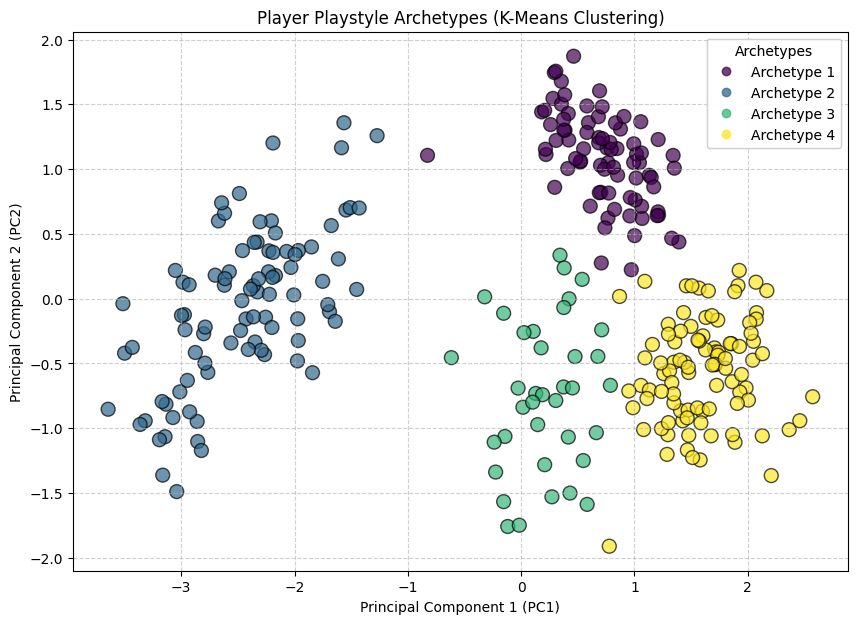


--- Running DBSCAN Clustering (eps=0.6, min_samples=5) ---
DBSCAN found 2 clusters and 29 noise points.

--- DBSCAN Archetype Analysis (3 Archetypes) ---
Mean feature values for each identified cluster:
         Pass_Freq_per_90  Shot_Attempts_per_90  Risk_Index  Aggression_Factor
Cluster                                                                       
-1                  69.97                  3.53        0.41               7.16
 0                  86.22                  1.31        0.19               6.14
 1                  39.76                  5.05        0.62               8.91


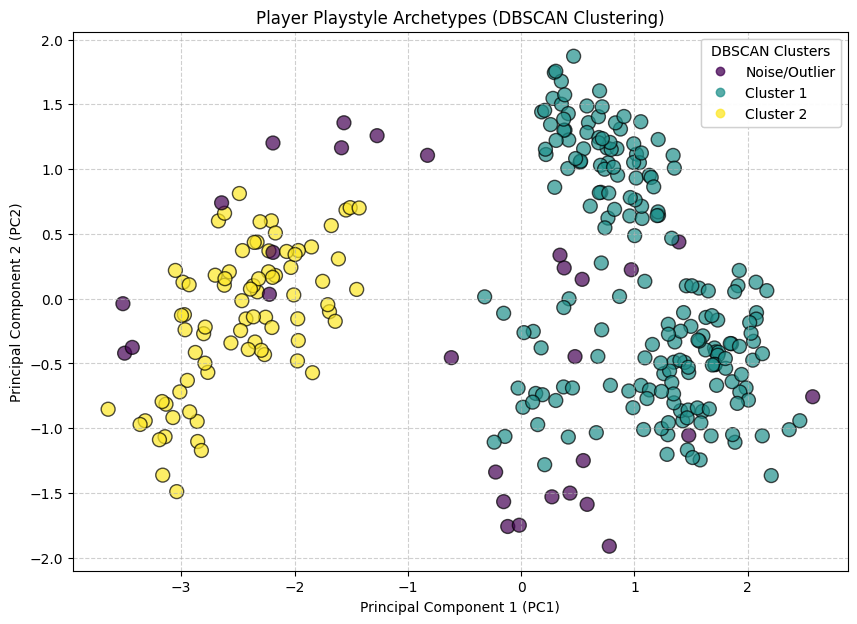


Project completed. Close the plots to finish the script.


In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# --- Configuration ---
RANDOM_STATE = 42
N_PLAYERS = 300
N_CLUSTERS_KMEANS = 4 # Starting assumption for K-Means archetypes

def simulate_player_data(n_players):
    """
    Simulates detailed player decision data based on four key playstyle dimensions.

    The data is generated with intentional clusters to make the unsupervised learning
    demonstration effective.
    """
    np.random.seed(RANDOM_STATE)

    # Define feature names
    features = ['Pass_Freq_per_90', 'Shot_Attempts_per_90', 'Risk_Index', 'Aggression_Factor']

    # Create distinct "hidden" archetypes for simulation
    data_sets = []

    # Archetype 1: Deep-Lying Playmakers (High Pass, Low Shot, Low Risk, Medium Aggression)
    data_sets.append(np.random.multivariate_normal(
        mean=[100, 1.5, 0.2, 5.0],
        cov=[[10, 0, 0, 0], [0, 0.5, 0, 0], [0, 0, 0.01, 0], [0, 0, 0, 1.0]],
        size=int(n_players * 0.3)
    ))

    # Archetype 2: Volume Shooters/Strikers (Low Pass, High Shot, Medium Risk, High Aggression)
    data_sets.append(np.random.multivariate_normal(
        mean=[40, 5.0, 0.6, 9.0],
        cov=[[5, 0, 0, 0], [0, 1.0, 0, 0], [0, 0, 0.05, 0], [0, 0, 0, 0.5]],
        size=int(n_players * 0.3)
    ))

    # Archetype 3: Defensive Specialists (Medium Pass, Very Low Shot, Low Risk, Medium-High Aggression)
    data_sets.append(np.random.multivariate_normal(
        mean=[70, 0.5, 0.1, 7.5],
        cov=[[8, 0, 0, 0], [0, 0.2, 0, 0], [0, 0, 0.005, 0], [0, 0, 0, 0.8]],
        size=int(n_players * 0.25)
    ))

    # Archetype 4: Box-to-Box Midfielders (High Pass, Medium Shot, Medium Risk, Medium Aggression)
    data_sets.append(np.random.multivariate_normal(
        mean=[85, 2.5, 0.4, 6.0],
        cov=[[12, 0, 0, 0], [0, 0.7, 0, 0], [0, 0, 0.03, 0], [0, 0, 0, 0.9]],
        size=n_players - sum(len(d) for d in data_sets)
    ))

    # Combine and clean up
    data = np.vstack(data_sets)
    df = pd.DataFrame(data, columns=features)
    # Ensure all values are non-negative and Risk_Index is capped at 1.0
    df = df.clip(lower=0)
    df['Risk_Index'] = df['Risk_Index'].clip(upper=1.0)

    # Add Player ID
    df.insert(0, 'Player_ID', [f'Player_{i+1}' for i in range(len(df))])

    print(f"--- Simulated Data Generated: {len(df)} players ---")
    print(df.head())
    return df

def preprocess_data(df):
    """Scales the numerical features for optimal clustering performance."""
    features_to_scale = df.columns.drop('Player_ID')
    X = df[features_to_scale]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, scaler, features_to_scale

def plot_clusters(X_pca, labels, title, method_name):
    """Visualizes the clusters after dimensionality reduction using PCA."""
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(
        X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=100, alpha=0.7, edgecolors='k'
    )
    plt.title(f'Player Playstyle Archetypes ({method_name} Clustering)')
    plt.xlabel('Principal Component 1 (PC1)')
    plt.ylabel('Principal Component 2 (PC2)')

    # Create legend handles for K-Means/DBSCAN results
    if method_name == 'K-Means':
        unique_labels = np.unique(labels)
        legend1 = plt.legend(
            handles=scatter.legend_elements()[0],
            labels=[f'Archetype {i+1}' for i in unique_labels],
            loc="upper right",
            title="Archetypes"
        )
        plt.gca().add_artist(legend1)
    elif method_name == 'DBSCAN':
        # -1 indicates noise in DBSCAN
        unique_labels = sorted(np.unique(labels))
        legend_labels = []
        for label in unique_labels:
            if label == -1:
                legend_labels.append('Noise/Outlier')
            else:
                legend_labels.append(f'Cluster {label+1}')

        legend1 = plt.legend(
            handles=scatter.legend_elements()[0],
            labels=legend_labels,
            loc="upper right",
            title="DBSCAN Clusters"
        )
        plt.gca().add_artist(legend1)

    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

def analyze_archetypes(df, labels, features_to_scale, method_name):
    """Calculates and prints the mean statistics for each identified archetype."""
    df_clustered = df.copy()
    df_clustered['Cluster'] = labels

    # Group by cluster and calculate the mean for each feature
    archetype_means = df_clustered.groupby('Cluster')[features_to_scale].mean()

    print(f"\n--- {method_name} Archetype Analysis ({len(archetype_means)} Archetypes) ---")
    print("Mean feature values for each identified cluster:")
    print(archetype_means.round(2))

    # Provide descriptive labels for K-Means archetypes based on highest/lowest values
    if method_name == 'K-Means':
        print("\nArchetype Descriptions:")
        for idx, row in archetype_means.iterrows():
            if idx == -1: continue # Skip noise/outlier if it was present

            # Find the feature with the highest mean value in the cluster
            highest_feature = row.idxmax().replace('_', ' ')

            description = (
                f"Archetype {idx+1}: "
                f"High {highest_feature}. "
                f"Characterized by: P90={row['Pass_Freq_per_90']:.1f}, "
                f"Shots={row['Shot_Attempts_per_90']:.1f}, "
                f"Risk={row['Risk_Index']:.2f}, "
                f"Aggression={row['Aggression_Factor']:.1f}"
            )
            print(description)

    return df_clustered

def run_clustering_kmeans(X_scaled, df, features_to_scale):
    """
    Applies K-Means clustering and analyzes the results.
    K-Means is ideal when you expect spherical clusters of similar sizes.
    """
    print("\n--- Running K-Means Clustering ---")

    # Step 1: Cluster the scaled data
    kmeans = KMeans(n_clusters=N_CLUSTERS_KMEANS, random_state=RANDOM_STATE, n_init=10)
    kmeans_labels = kmeans.fit_predict(X_scaled)

    # Step 2: Reduce dimensions for plotting
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    X_pca = pca.fit_transform(X_scaled)

    # Step 3: Analyze and Visualize
    df_clustered = analyze_archetypes(df, kmeans_labels, features_to_scale, 'K-Means')
    plot_clusters(X_pca, kmeans_labels, 'K-Means Clustering', 'K-Means')

    return df_clustered

def run_clustering_dbscan(X_scaled, df, features_to_scale, eps=0.5, min_samples=5):
    """
    Applies DBSCAN clustering and analyzes the results.
    DBSCAN is ideal for finding arbitrarily shaped clusters and identifying noise/outliers.
    """
    print(f"\n--- Running DBSCAN Clustering (eps={eps}, min_samples={min_samples}) ---")

    # Step 1: Cluster the scaled data
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(X_scaled)
    n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = list(dbscan_labels).count(-1)

    print(f"DBSCAN found {n_clusters} clusters and {n_noise} noise points.")

    # Step 2: Reduce dimensions for plotting
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    X_pca = pca.fit_transform(X_scaled)

    # Step 3: Analyze and Visualize
    # Filter out noise (-1) for meaningful archetype analysis if needed, but analyze_archetypes handles it.
    df_clustered = analyze_archetypes(df, dbscan_labels, features_to_scale, 'DBSCAN')
    plot_clusters(X_pca, dbscan_labels, 'DBSCAN Clustering', 'DBSCAN')

    return df_clustered


def main():
    """Orchestrates the data simulation, preprocessing, clustering, and visualization."""

    # 1. Data Simulation
    player_data_df = simulate_player_data(N_PLAYERS)

    # 2. Data Preprocessing
    X_scaled, scaler, features = preprocess_data(player_data_df)

    # 3. Run K-Means Clustering (The primary method for finding 'N' archetypes)
    _ = run_clustering_kmeans(X_scaled, player_data_df, features)

    # 4. Run DBSCAN Clustering (An alternative for density-based grouping and outlier detection)
    # The default parameters (eps=0.5, min_samples=5) are chosen based on the scaled data.
    _ = run_clustering_dbscan(X_scaled, player_data_df, features, eps=0.6, min_samples=5)

    print("\nProject completed. Close the plots to finish the script.")

if __name__ == "__main__":
    main()